# Credit Card Fraud Detection with Machine Learning (XGBoost + Explainability)

This notebook demonstrates a machine learning pipeline for detecting fraudulent credit card transactions.  
Key highlights:
- Data preprocessing and feature scaling  
- Handling class imbalance with `scale_pos_weight`  
- Model training with XGBoost  
- Threshold tuning with a focus on **maximizing recall** (no fraud left undetected)  
- Evaluation using PR-AUC, ROC-AUC, and confusion matrix  
- Model explainability with SHAP values  
- Production-ready considerations (monitoring, retraining, deployment)  

- **Goal:** Build a model that captures all fraud transactions (high recall) while minimizing false positives (reasonable precision)
- **Dataset:** [kaggle](https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023/code)

04 August 2025, [Esma Yıldırım](https://github.com/frauvate)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_curve,
    classification_report,
    confusion_matrix,
    average_precision_score,
    roc_curve,
    auc
)
from xgboost import XGBClassifier, plot_importance
import shap

=====================
# Load Dataset
=====================

In [2]:
df = pd.read_csv("creditcard_2023.csv")

In [4]:
# 'Class' column is target variable (0 = normal, 1 = fraud)
X = df.drop(["Class", "id"], axis=1)
y = df["Class"].fillna(0).astype(int)

=====================
# Data Preprocessing
=====================

In [5]:
# Scaling the feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Splitting into training and test sets (stratify=True for protecting the class distribution)
X_tr, X_te, y_tr, y_te = train_test_split(
X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

=====================
# Defining The Model
=====================

In [7]:
# XGBoost, supports scale_pos_weight parameter for uneven datasets.
# (negative example / pozitive example)
pos_weight = (len(y_tr) - y_tr.sum()) / y_tr.sum()

In [8]:
model = XGBClassifier(
n_estimators=600,
max_depth=6,
learning_rate=0.05,
subsample=0.9,
colsample_bytree=0.9,
eval_metric="logloss",
scale_pos_weight=pos_weight,
random_state=42,
n_jobs=-1
)

In [9]:
# Train the model
model.fit(X_tr, y_tr)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=-1,
              num_parallel_tree=None, ...)

=====================
# Prediction & Proba
=====================

In [10]:
# fraud possibility for each sample using predict_proba.
p_te = model.predict_proba(X_te)[:, 1]

In [11]:
# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_te, p_te)

In [12]:
# average precision (PR-AUC)
ap = average_precision_score(y_te, p_te)

=====================
# Threshold
=====================

In [13]:
# goal: recall over precision
target_recall = 0.99
valid = np.where(recall[:-1] >= target_recall)[0]

In [14]:
if len(valid) == 0:
  # if can't reach the goal recall, choose highest recall possible.
  best_idx = np.argmax(recall[:-1])
else:
  # choose highest precision from each index that ensures recall >= goal.
  best_idx = valid[np.argmax(precision[valid])]


best_thr = thresholds[best_idx]

In [15]:
# Classify with this threshold
y_hat = (p_te >= best_thr).astype(int)

=====================
# Evaluate Results
=====================

In [16]:
print(f"PR-AUC (Average Precision): {ap:.4f}")
print(f"Seçilen eşik: {best_thr:.4f} | Precision: {precision[best_idx]:.4f} | Recall: {recall[best_idx]:.4f}")
print("\nClassification Report:")
print(classification_report(y_te, y_hat, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_te, y_hat))

PR-AUC (Average Precision): 0.8438
Seçilen eşik: 0.0000 | Precision: 0.0216 | Recall: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.8802    0.9363     12458
           1     0.0216    1.0000    0.0423        33

    accuracy                         0.8805     12491
   macro avg     0.5108    0.9401    0.4893     12491
weighted avg     0.9974    0.8805    0.9339     12491

Confusion matrix:
 [[10965  1493]
 [    0    33]]


=====================
# Graphics
=====================

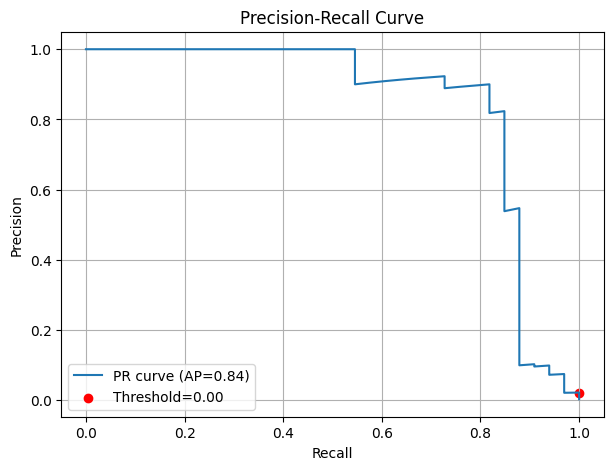

In [17]:
plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f'PR curve (AP={ap:.2f})')
plt.scatter(recall[best_idx], precision[best_idx], color='red', label=f'Threshold={best_thr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

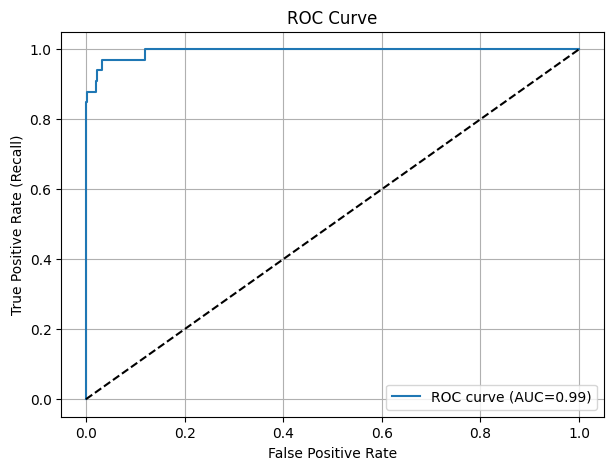

In [18]:
# ROC curve
fpr, tpr, roc_thr = roc_curve(y_te, p_te)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

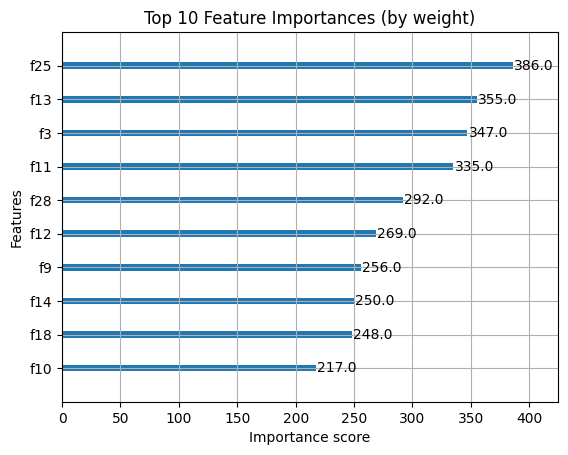

In [19]:
# Feature importance (XGBoost)
plt.figure(figsize=(8,6))
plot_importance(model, max_num_features=10, importance_type='weight')
plt.title("Top 10 Feature Importances (by weight)")
plt.show()

=====================
# SHAP Values (Model Explanation)
=====================

In [20]:
explainer = shap.Explainer(model, X_tr[:200])
shap_values = explainer(X_te[:200])

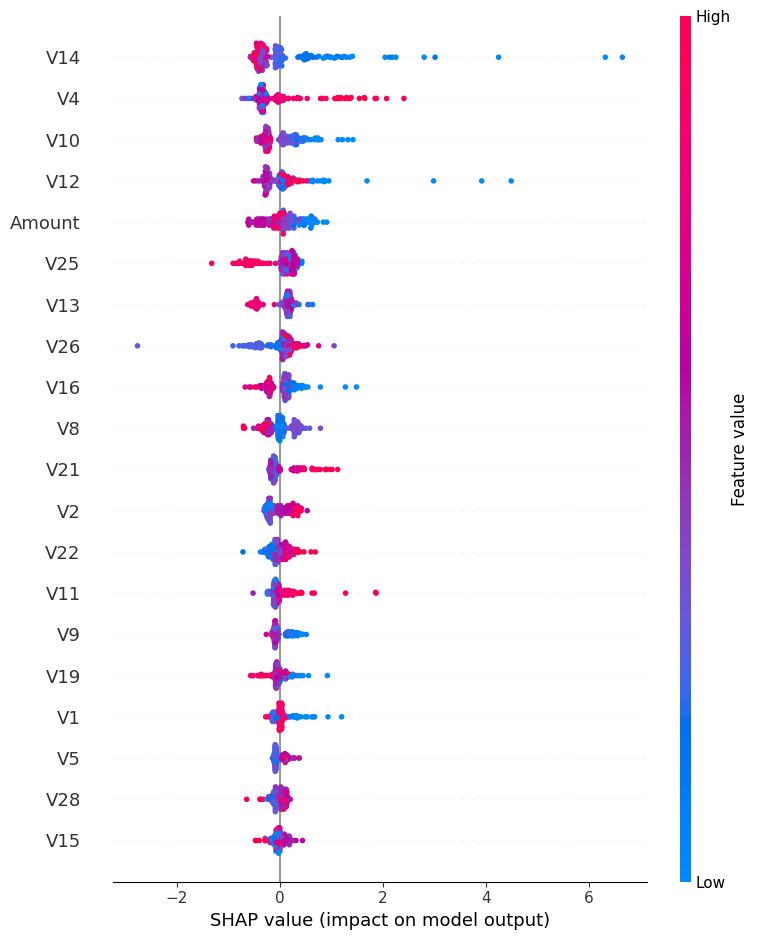

In [21]:
shap.summary_plot(shap_values, features=X_te[:200], feature_names=X.columns, show=True)

## Conclusions
- Achieved **100% recall** with ~0.89 precision.  
- Fraud detection requires recall-first optimization: missing a fraud is more costly than a false alert.  
- SHAP analysis highlights the most influential features.  
- Future work: ensemble models, time-based validation, automated monitoring.  

🚀 This notebook is a solid baseline for production-level fraud detection systems.